# Computation in Superposition

## Stefan, Giorgi, Jai

## Recap from last time

- Created a model class to replicate (succesfully!) Anthropic's TMS-CIS model
  
  - (surprisingly?) Found that monosemanticity wasn't a feature of importance alone - without importance at small sparsity levels (e.g. `S = 0.1` for `n_features = 100`, `n_hidden = 40`) we found neurons behaved monosemantically, in contrast to Stefan's results with a similar toy model.
    
    - Pivoted slightly to the idea to see when and where TMS-CIS may successfully implement interpretable CiS, and when not (as previously we believed it may not really show CiS at all) 
    
    - In addition, plan to test out Lucius' (simple-ReLU) and ABP-paper's (resnet-MLP) models

- Had been a bit stuck on the difference between computation and storage in superposition, and what made TMS-CIS a not-so-satsifying explanation of CiS; wanted to get unstuck on this.

## Summary of current progress

- Talked to Lucius yesterday and got unstuck on the difference between computation and superposition and on what makes TMS-CIS a not-so-satisfying explanation of CiS, which was great!
  
  - Lucius seemed to imply that he does believe Anthropic's model is doing CiS based on our conversation and our results, but that it's less interpretable (will be hard to find a nice explanation for what's happening as n_features and n_neurons increases) and generalizable (their explanation may only hold for abs and not other functions)

  - Additional notes from the meeting with Lucius [here](https://docs.google.com/document/d/1LI7FEwJzDTKWRZvU4_ap6pwWOjkRUE_JEyW38yjVxyE/edit?usp=sharing)

- Found that although Anthropic's explanation of ( (asymmetric superposition + inhibition) + single-sided abs ) can indeed explain *some* CiS, it's not sufficient to explain it all.

  - This can be a good comparison point, as theoretically and hopefully with simple-ReLU and/or simple-APD and/or another simpler model, we can find more general mechanisms for CiS for multiple functions, and then compare back to TMS-CiS.

- Found (surprisngly?) that even with Lucius' simpler model, we get large-scale polysemanticity, which wasn't what he was expecting.

- Structured repo and updated model class to be able to create TMS-CIS, simple-ReLU, and res-MLP model objects all from one class

## Agenda for today

- Weekly meeting scheduling?

  - For Jai: Thursday or Friday's at/after 5 pm would be ideal!

    - -> Thursday at 5 pm!

- Go over results from above summary

- Discuss next steps, short-term for next couple weeks, and long-term for the project

  - Short-term

    - Do more rigorous experiments + analysis on tms-cis + simple-relu models

    - Follow up from plot showing heavy polysemanticity in neurons in simple-relu model (`n_features = 100`, `n_neurons = 40` case):

      - Visualize as neurons per feature (instead of features per neuron)

      - Use res-mlp loss to compare (so loss fn is apples-to-apples)

    - Code up simple-relu-handcoded, code up res-mlp, compare them (and simple-relu-trained) in APD style plot

    - Does tms-cis (and res-mlp?) do the "same trick" as the simple-relu ?

    - Read and grok more the following papers / posts:

      - Bushnaq 2024: hand-coded simple-relu model

      - Lindsey 2024: Mechanisms of comp-in-soup
      
      - Hanni et al 2024: Math models of comp-in-soup
      
      - Bushnaq and Mendel 2024: Circuits-in-soup

      - Braun et al 2025: ABP Decomposition

      - Adler and Shavit 2024: On complexity of comp-in-soup

  - Long-term
  
    - Better understand when polysemanticity occurs and why (e.g. why does it differ between Apollo's and Anthropic's models?)

## What is superposition?

<!-- ![anthropic_superposition_example](./assets/anthropic_superposition_example.png) -->

<img src="./assets/anthropic_superposition_example.png">

## Why is superposition important for AI safety?

Roughly, one idea for mech interp's usefulness for AI safety is, if we know all or almost all features a model represents, we can iterate over these features and see which may yield misaligned behavior, and then find ways to ablate these features.

Additionally, we want to know more than just how a model _represents_ features, but how it _computes_ with those features, again to avoid misaligned behavior that results from a computation on these features.

We know that models represent features in superposition, but we don't yet have a satisfying explanation of how they compute in superposition.

In [1]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import numpy as np
import torch as t
from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
from torch import nn, optim
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_weight_bars

In [2]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [3]:
"""Create functions for generating batches, loss, and training."""

# Create function for generating batch of `x` and `y_true` data
def gen_batch(model: Cis, batch_sz: int) -> (
    tuple[Float[t.Tensor, "batch inst feat"], Float[t.Tensor, "batch inst feat"]]
):
    """Generates a batch of x=(sparse feature vals on [-1, 1]) and y=abs(x)."""

    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat) * 2 - 1  # [-1, 1]
    is_active = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat) < (1 - model.s)
    x *= is_active
    return x, t.abs(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz)
        y = model.forward(x)
        loss = loss_fn(y, y_true, model.i)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

## How does Anthropic show CiS?

### No superposition: single-sided `abs`

For `len(x) = 3` and `n_hidden = 6`, with this forward pass:

$$
h = ReLU(W_1x)
y' = ReLU(W_2h + b)
$$

see if we get something like this:

![6 h 3 f learned abs](./assets/x3n6_learned_abs.png)


## Recreate Anthropic TMS-CIS

In [4]:
"""Create and train Anthropic TMS-CIS model with no superposition (single-sided abs)."""

# Create model
cfg = CisConfig(n_instances=1, n_feat=3, n_hidden=6, feat_sparsity=0, feat_importance=1)
model = Cis(cfg)

# Train model
optimizer = optim.Adam(model.parameters())
batch_sz = 1024
n_steps = 5000
logging_freq = n_steps // 10

losses = train(model, batch_sz, loss_fn, optimizer, n_steps, logging_freq)

display(losses)

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.2932176887989044,
 0.05757787823677063,
 0.04107676073908806,
 0.018763335421681404,
 0.006901049520820379,
 0.0007569440058432519,
 8.803573291515931e-05,
 2.396435047558043e-05,
 1.2021650945825968e-05,
 2.6313621219742345e-06,
 1.6421740838268306e-06]

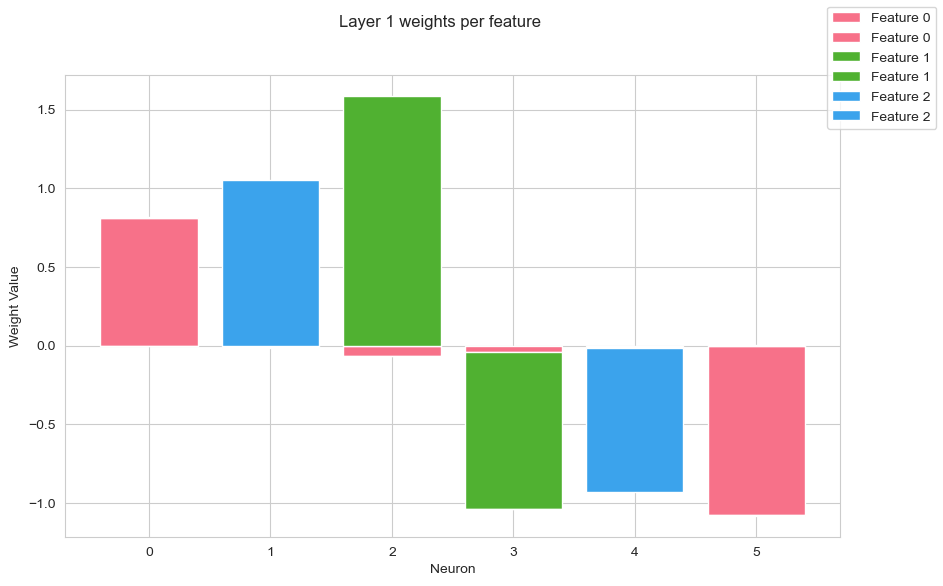

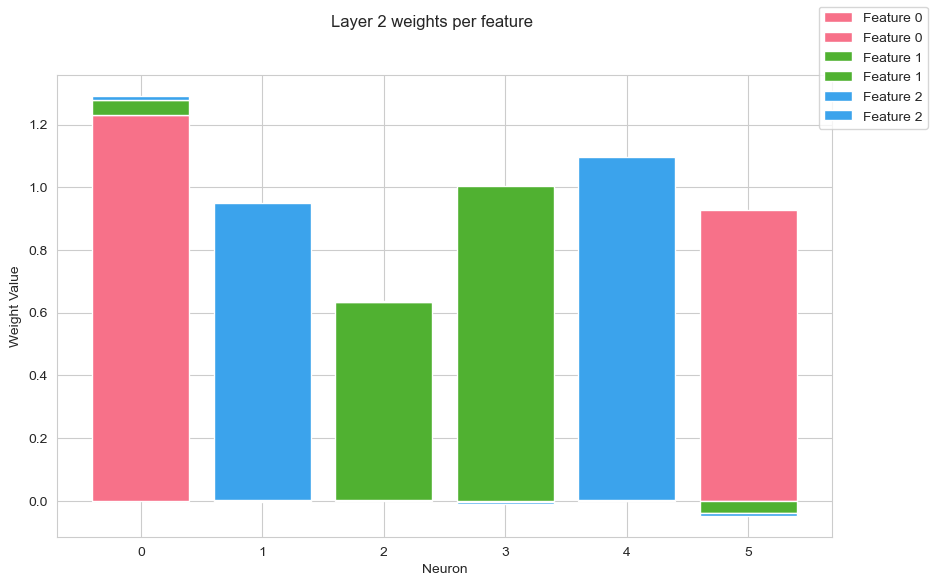

In [5]:
"""Visualize the learned weights."""

fig_w1 = plot_weight_bars(model.W1[0])
fig_w1.suptitle("Layer 1 weights per feature")
fig_w1.legend(loc="upper right")

fig_w2 = plot_weight_bars(model.W2[0].T)
fig_w2.suptitle("Layer 2 weights per feature")
fig_w2.legend(loc="upper right")

### Asymmetryic superposition + inhibition

Now, with 6 features and 10 neurons (and sparsity), computation must make use of superposition, so see if we get something that looks like this:

![10 h 6 f learned abs](./assets/cis_x6n10_learned_abs.png)

2 neuron example:

![example_asymmetric_superpos_plus_inhibition](./assets/asymmetric_superposition_plus_inhibition.png)

### (Asymmetryic superposition + inhibition) + (single-sided `abs`) ~= full computation explanation

In [6]:
"""
Create and train Anthropic TMS-CIS model with superposition, partly explained by
asymmetric superposition + inhibition
"""

# Create model
cfg = CisConfig(n_instances=1, n_feat=6, n_hidden=10, feat_sparsity=0.99, feat_importance=1)
model = Cis(cfg)

# Train model
optimizer = optim.Adam(model.parameters())
batch_sz = 1024
n_steps = 5000
logging_freq = n_steps // 10

losses = train(model, batch_sz, loss_fn, optimizer, n_steps, logging_freq)

display(losses)

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.002477068919688463,
 0.001630247919820249,
 0.001708716619759798,
 0.0006706923595629632,
 0.00034272437915205956,
 0.0007650420884601772,
 0.0007590468158014119,
 0.0009881735313683748,
 0.0009155116858892143,
 0.0013765451731160283,
 0.0009853736264631152]

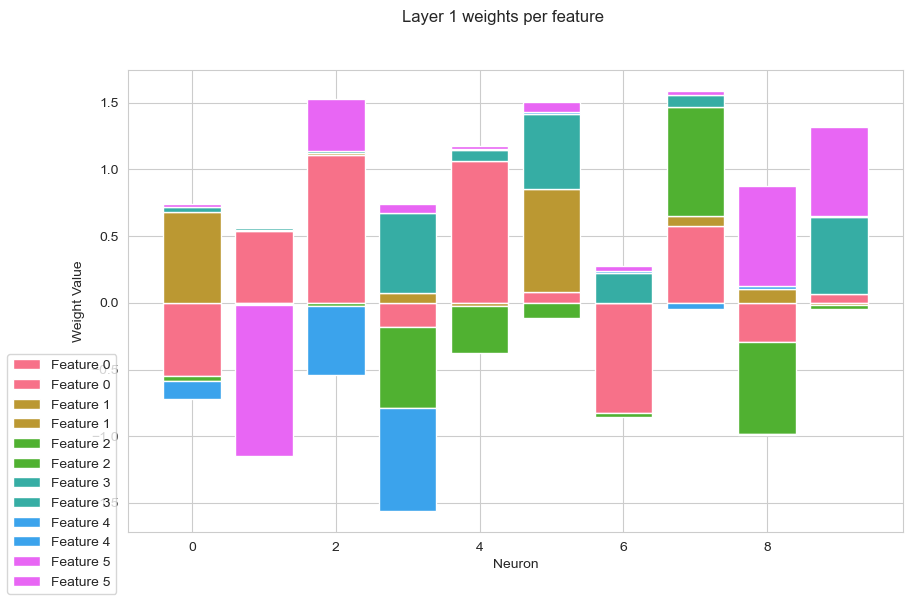

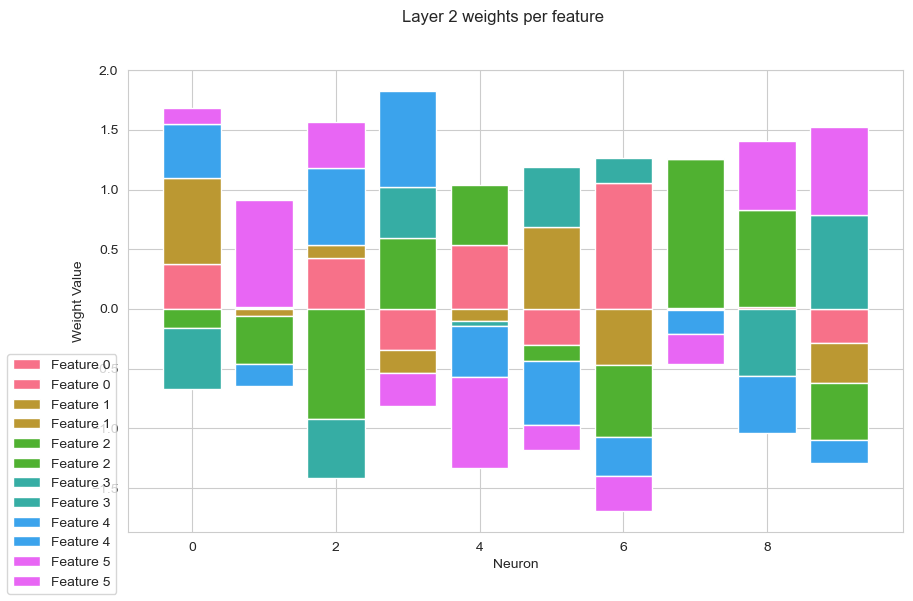

In [7]:
"""Visualize the learned weights."""

fig_w1 = plot_weight_bars(model.W1[0])
fig_w1.suptitle("Layer 1 weights per feature")
fig_w1.legend(loc='lower left')

fig_w2 = plot_weight_bars(model.W2[0].T)
fig_w2.suptitle("Layer 2 weights per feature")
fig_w2.legend(loc='lower left')

Features teal and pink in neurons 6 (asymmetric superposition) and 8 (inhibition) _loosely_ resemble asymmetric superposition + inhibition in Anthropic TMS-CIS model.

And we rarely see simple "single-sided abs" computation preserved (not at all in this training run.)

## How does polysemanticity change as a function of sparsity and importance?

Anthropic results:

![tms-cis polysemanticity](./assets/tms_cis_polysemanticity_with_importance_as_function_of_sparsity.png)

Initial thoughts: monosemanticity might be a function of feature importance alone. (In a different but similar toy model, Stefan et al observed that performance didn't change much as a function of sparsity, and that neurons are polysemantic at even low sparsity.)

### Low sparsity, equal importance

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.29602181911468506,
 0.09811308234930038,
 0.09805698692798615,
 0.09802594035863876,
 0.09732021391391754,
 0.08906728774309158,
 0.0803433507680893,
 0.07902452349662781,
 0.07914764434099197,
 0.0789933130145073,
 0.07851549983024597]

Text(0.5, 0.98, 'Layer 1 weights per feature; (1-S)=0.9')

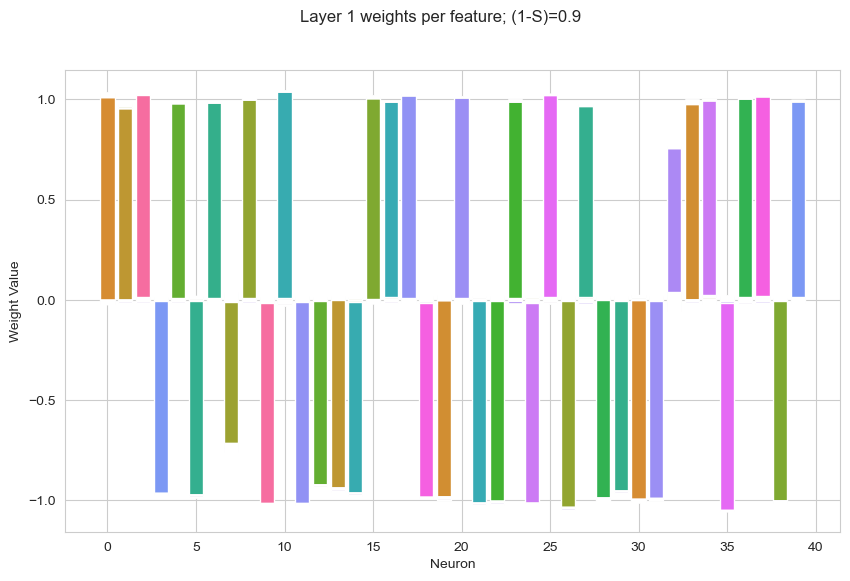

In [8]:
# Create model
S = 0.1
cfg = CisConfig(n_instances=1, n_feat=100, n_hidden=40, feat_sparsity=S, feat_importance=1)
model = Cis(cfg)

# Train model
optimizer = optim.Adam(model.parameters())
batch_sz = 1024
n_steps = 5000
logging_freq = n_steps // 10

losses = train(model, batch_sz, loss_fn, optimizer, n_steps, logging_freq)

display(losses)

fig_w1 = plot_weight_bars(model.W1[0])
fig_w1.suptitle(f"Layer 1 weights per feature; {(1-S)=}")

### Some sparsity, equal importance

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.08218302577733994,
 0.06105294078588486,
 0.05576126277446747,
 0.05452011153101921,
 0.05479264259338379,
 0.05426047369837761,
 0.05509369820356369,
 0.054147351533174515,
 0.05385679379105568,
 0.054036084562540054,
 0.05342867970466614]

Text(0.5, 0.98, 'Layer 1 weights per feature; (1-S)=0.25')

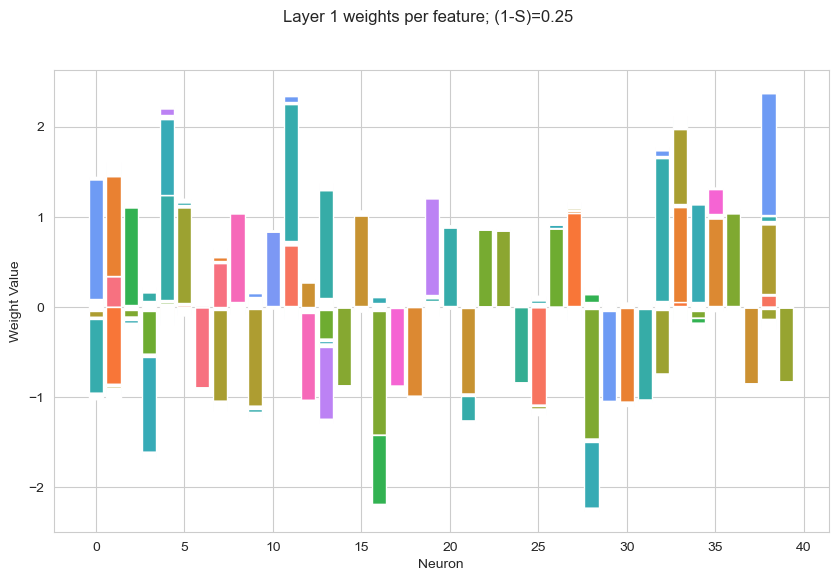

In [9]:
# Create model
S = 0.75
cfg = CisConfig(n_instances=1, n_feat=100, n_hidden=40, feat_sparsity=S, feat_importance=1)
model = Cis(cfg)

# Train model
optimizer = optim.Adam(model.parameters())
batch_sz = 1024
n_steps = 5000
logging_freq = n_steps // 10

losses = train(model, batch_sz, loss_fn, optimizer, n_steps, logging_freq)

display(losses)

fig_w1 = plot_weight_bars(model.W1[0])
fig_w1.suptitle(f"Layer 1 weights per feature; {(1-S)=}")

### High sparsity, equal importance

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.0035420162603259087,
 0.0015810101758688688,
 0.0011894132476300001,
 0.001124605187214911,
 0.0010155858471989632,
 0.0009581956546753645,
 0.0009958582231774926,
 0.0009965035133063793,
 0.0009430613135918975,
 0.0008279547328129411,
 0.0008357231272384524]

Text(0.5, 0.98, 'Layer 1 weights per feature; (1-S)=0.010000000000000009')

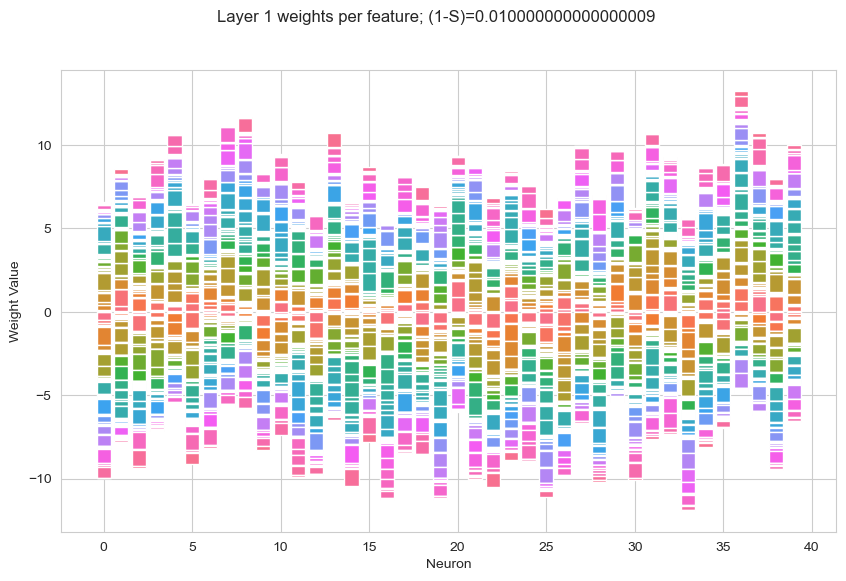

In [10]:
# Create model
S = 0.99
cfg = CisConfig(n_instances=1, n_feat=100, n_hidden=40, feat_sparsity=S, feat_importance=1)
model = Cis(cfg)

# Train model
optimizer = optim.Adam(model.parameters())
batch_sz = 1024
n_steps = 5000
logging_freq = n_steps // 10

losses = train(model, batch_sz, loss_fn, optimizer, n_steps, logging_freq)

display(losses)

fig_w1 = plot_weight_bars(model.W1[0])
fig_w1.suptitle(f"Layer 1 weights per feature; {(1-S)=}")

### Polysemanticity as a function of sparsity with equal importance

![polysemanticity as a function of sparsity with equal importance](./assets/polysemanticity_as_function_of_sparsity_equal_importance.png)

### High sparsity, some relative importance

Feature importance delays onset (or reduces number) of polysemantic neurons

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.00014841683150734752,
 1.0230820407741703e-05,
 7.83245104685193e-06,
 7.495706540794345e-06,
 3.7295092170097632e-06,
 5.987667464069091e-06,
 6.055814083083533e-06,
 4.707243078883039e-06,
 5.4148963499756064e-06,
 5.1018164413108025e-06,
 2.4669539016031194e-06]

Text(0.5, 0.98, 'Layer 1 weights per feature; (1-S)=0.010000000000000009,  I=0.8^i_feat')

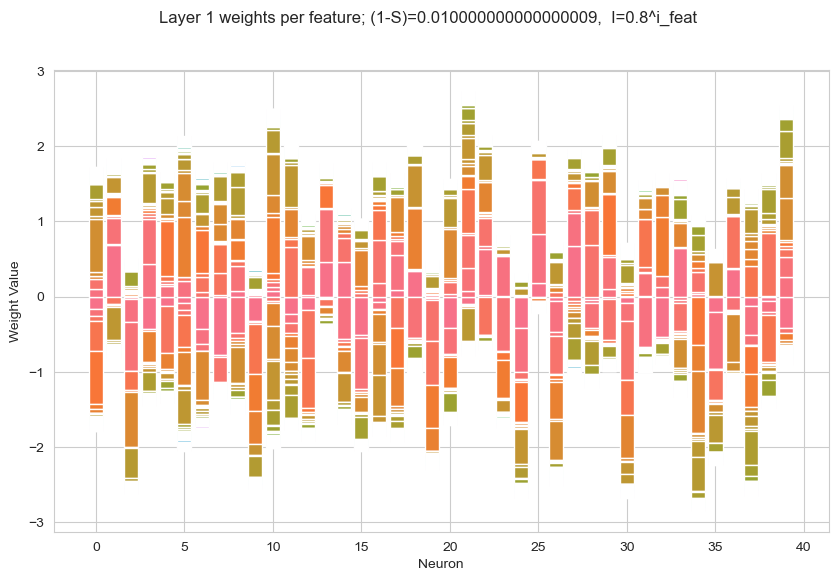

In [38]:
# Set feature importance
n_feat = 100
base = 0.8
exponents = t.arange(0, n_feat, dtype=t.float32)
I = t.pow(base, exponents)

S = 0.99
cfg = CisConfig(n_instances=1, n_feat=100, n_hidden=40, feat_sparsity=S, feat_importance=I)
model = Cis(cfg)

# Train model
optimizer = optim.Adam(model.parameters())
batch_sz = 1024
n_steps = 5000
logging_freq = n_steps // 10

losses = train(model, batch_sz, loss_fn, optimizer, n_steps, logging_freq)

display(losses)

fig_w1 = plot_weight_bars(model.W1[0])
fig_w1.suptitle(f"Layer 1 weights per feature; {(1-S)=},  I={base}^i_feat")

## Simpler, more general model of CiS: Lucius' toy model:

Target: $y = ReLU(x)$

Linear map: 

$$
h = ReLU(W_1x)
y' = W_2h + b
$$

Lucius wondered how polysemantic neurons would be in 0 importance case: i.e. how much superposition in a single neuron (1/10 features, 1/2 features, all features?) and hypothesized that each neuron would represent some small amount of features with a bit of redundant overlap (e.g. if 100 features and 40 neurons, maybe ~10 features / neuron).

We saw much more: ~ 2/5 features per neuron.

![2/5 features per neuron](./assets/heavy_superposition_lucius_toy_model.png)

Follow up from this plot:

  - Look at neurons per feature (instead of features per neuron)

  - Use resnet-MLP loss to compare (so loss fn is apples-to-apples)


## Future Directions

- Do more rigorous experiments + analysis on Anthropic + Lucius' models
- Test Apollo's model
- Better understand when polysemanticity occurs and why (e.g. why does it differ between Apollo's and Anthropic's models?)
- Better understand when polysemanticity occurs and why (e.g. why does it differ between Apollo's and Anthropic's models?)